# Tema 7

Sa se creeze si antreneze o retea de tip convolutional pentru unul din seturile de date [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html), [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), [Food101](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html). Intrarea este RGB, de forma 32 x 32 x 3 (la CIFAR10, 100) si dimensiune (max 512) x (max 512) x 3 pentru Food101. 

Cerinte:
1. Efectuati minim 50 de epoci de instruire. 
1. Reprezentati grafic evolutia functiei de cost si a acuratetei, masurate pe setul de antrenare si de validare, folosind tensorboard. **Fisierele tfevents vor fi incluse in arhiva zip care se preda pe elearning**. 
1. Acuratetea unui model neantrenat este de in medie 1/(numarul de clase), adica modelul decide aleator o clasa pentru fiecare input. Modelul vostru va trebui sa ajunga mult peste acest prag de baza. 
1. Cautare de learning rate (LR) cat mai bun: odata gasit arhitectura care performeaza peste pragul de baza, incercati 3 valori diferite pentru hiperparametrul learning rate. Modelul va fi antrenat pe un prcent de 90% de imagini alese aleator din setul de antrenare si validat pe restul de 10% imagini din setul de antrenare. Acel LR care produce cea mai buna acuratete pe setul de validare va fi folosit pentru antrenarea peste toate imaginile din setul initial de antrenare si in final testat pe setul de testare. Setul de testare nu se va folosi in etapa de antrenare sau de validare (cautare de LR optimal).
2. Se va face scalarea datelor din setul de antrenare si de validare, calculand media si deviatia standard pe setul de antrenare; vor rezulta 2 tensori cu cate 3 dimensiuni (cate o valoare pentru canalele R, G, B); se poate folosi functia `compute_mean_std` din prezentarea de laborator. 

Tema va fi predata pana in **22 mai 2024 ora 23** pe elearning. Notarea ei se va face doar in prezenta studentului.

## Import de pachete

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from typing import Tuple

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

C:\Users\Filip\anaconda3\envs\ISML\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using PyTorch version: 2.2.0  Device: cpu


In [6]:
!pip install torchinfo
from torchinfo import summary

!pip install tensorboard
from torch.utils.tensorboard import SummaryWriter

## Pregatire dataset, dataloader

Codul de mai jos e un punct de plecare posibil / exemplu pentru setul CIFAR100. Utilizarea acestui cod nu e mandatorie. 

In [7]:
def compute_mean_std(train_data: datasets.MNIST) -> Tuple[torch.Tensor, torch.Tensor]:
    channel_sum, channel_squared_sum = 0, 0
    for data, _ in train_data:
        channel_sum += torch.mean(data, dim=[1, 2])
        channel_squared_sum += torch.mean(data**2, dim=[1, 2])

    mean = channel_sum / len(train_data)
    std = (channel_squared_sum / len(train_data) - mean**2) ** 0.5

    return mean, std

In [8]:
# se poate ajusta dimensiunea batchului
batch_size = 32

train_dataset = datasets.CIFAR100('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

assert len(train_dataset) == 50000

# pentru standardizarea datelor calculam valoare medie si deviatia standard pe cele 3 canale de intrare ale fiecare imagini
mean_train, std_train = compute_mean_std(train_dataset)

# transformarile care se aplica pentru fiecare imagine din set de train sau de validare
image_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean_train, std_train)])

train_dataset = datasets.CIFAR100('./data', 
                               train=True, 
                               download=True, 
                               transform=image_transform)

test_dataset = datasets.CIFAR100('./data', 
                                    train=False, 
                                    transform=image_transform)

assert len(test_dataset) == 10000



Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

Nota: daca celula de plot produce eroare, atunci se foloseste workaround de la [https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial](https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial):"

In [13]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [14]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

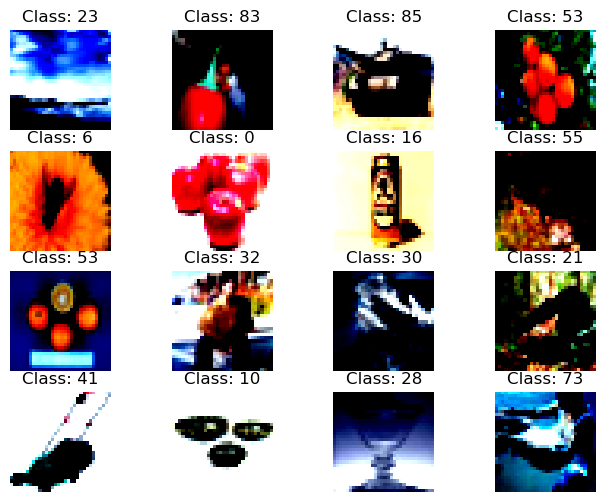

In [15]:
pltsize=1
plt.figure(figsize=(8, 6))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(3,32,32).transpose(1,2,0))
    plt.title('Class: '+str(y_train[i].item()))

## Functii: antrenare, validare, desenare

Definiti in mod convenabil functii de antrenare si de validare. Puteti reutiliza cod din notebook-urile anterioare. 

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 100)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
print(model)
# summary(model, input_size=(batch_size, 3, 32, 32))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
#functie de antrnare
def train(model: nn.Module, 
          optimizer: torch.optim.Optimizer, 
          criterion: callable, 
          train_loader: torch.utils.data.DataLoader, 
          epoch: int,
          log_interval: int=10,
          writer: SummaryWriter=None) -> None:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tBatch loss: {loss.item():.6f}')
            if writer:
                writer.add_scalar('Training Loss', running_loss / log_interval, epoch * len(train_loader) + batch_idx)
            running_loss = 0.0
    accuracy = 100. * correct / total
    return running_loss / len(train_loader), accuracy

In [20]:
#functie de validare
def validate(model: nn.Module, 
             criterion: callable, 
             test_loader: torch.utils.data.DataLoader, 
             device: torch.device, 
             epoch: int, 
             writer: SummaryWriter=None) -> Tuple[float, float]:
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader.dataset)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.3f}, Accuracy: {val_accuracy:.3f}%')

    if writer:
        writer.add_scalar('Validation Loss', val_loss, epoch)
        writer.add_scalar('Validation Accuracy', val_accuracy, epoch)

    return val_loss, val_accuracy


In [21]:
#functie de desenare
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

## Definire model

In [22]:
summary(model)

Layer (type:depth-idx)                   Param #
SimpleCNN                                --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            1,049,088
├─Linear: 1-6                            51,300
├─Dropout: 1-7                           --
Total params: 1,193,636
Trainable params: 1,193,636
Non-trainable params: 0

## Antrenare si validare

Se vor tipari si prezenta ploturi (loss, acuratete) pe seturile de antrenare si validare la finalul fiecarei epoci.

Train Epoch: 0 [0/50000 (0%)]	Batch loss: 4.611456
Train Epoch: 0 [320/50000 (1%)]	Batch loss: 4.599460
Train Epoch: 0 [640/50000 (1%)]	Batch loss: 4.588934
Train Epoch: 0 [960/50000 (2%)]	Batch loss: 4.600506
Train Epoch: 0 [1280/50000 (3%)]	Batch loss: 4.582832
Train Epoch: 0 [1600/50000 (3%)]	Batch loss: 4.597341
Train Epoch: 0 [1920/50000 (4%)]	Batch loss: 4.591927
Train Epoch: 0 [2240/50000 (4%)]	Batch loss: 4.591308
Train Epoch: 0 [2560/50000 (5%)]	Batch loss: 4.569200
Train Epoch: 0 [2880/50000 (6%)]	Batch loss: 4.601232
Train Epoch: 0 [3200/50000 (6%)]	Batch loss: 4.609999
Train Epoch: 0 [3520/50000 (7%)]	Batch loss: 4.516194
Train Epoch: 0 [3840/50000 (8%)]	Batch loss: 4.474966
Train Epoch: 0 [4160/50000 (8%)]	Batch loss: 4.473217
Train Epoch: 0 [4480/50000 (9%)]	Batch loss: 4.501119
Train Epoch: 0 [4800/50000 (10%)]	Batch loss: 4.530503
Train Epoch: 0 [5120/50000 (10%)]	Batch loss: 4.453054
Train Epoch: 0 [5440/50000 (11%)]	Batch loss: 4.504499
Train Epoch: 0 [5760/50000 (12%

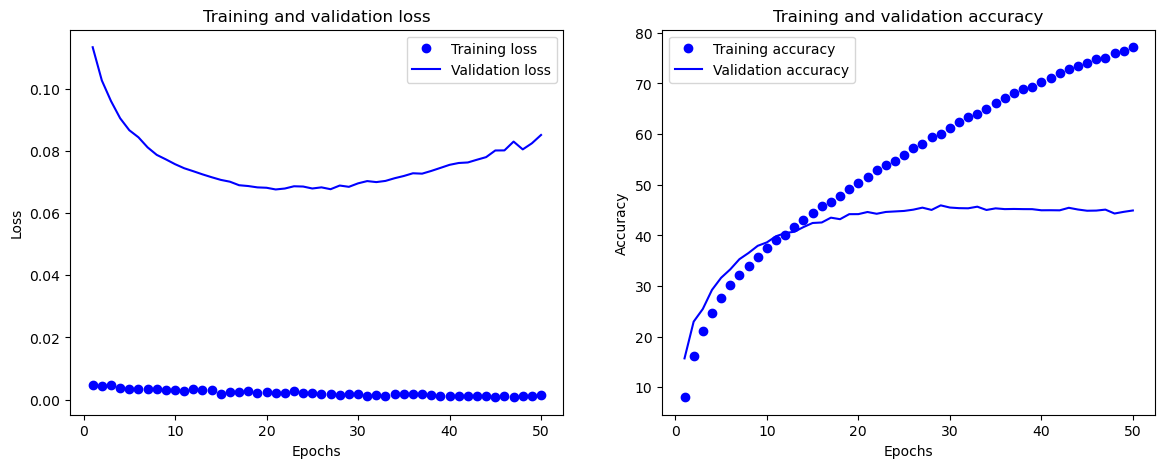

Run 'tensorboard --logdir=runs' to view the TensorBoard


In [23]:
# Bucla principală de antrenare
writer = SummaryWriter('runs/CNN_CIFAR10')

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, epoch, log_interval=10, writer=writer)
    val_loss, val_accuracy = validate(model, criterion, test_loader, device, epoch, writer=writer)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

writer.close()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

print("Run 'tensorboard --logdir=runs' to view the TensorBoard")